In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from data_utils import load_CIFAR10
from keras.datasets import cifar10
from numpy import argmax

Using TensorFlow backend.


In [2]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

In [3]:
n=12
depth = n * 6 + 2
cifar10_dir = 'cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
input_shape = x_train.shape[1:]
#batch normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [5]:
#code adapted from cs231 stanford
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True,
conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



In [6]:
def resnet(input_shape, depth, num_classes=10):
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax', kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
model = resnet(input_shape=input_shape, depth=depth)

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True)
lr_scheduler = LearningRateScheduler(lr_schedule)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, lr_scheduler]



Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [9]:
print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history= model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 132s 85ms/step - loss: 2.0514 - acc: 0.4984 - val_loss: 2.0155 - val_acc: 0.4384

Epoch 00001: val_acc improved from -inf to 0.43840, saving model to /home/seifhelal/Desktop/saved_models/cifar10_model.001.h5
Epoch 2/200
Learning rate:  0.001
1563/1563 [==============================] - 127s 81ms/step - loss: 1.4157 - acc: 0.6347 - val_loss: 1.5144 - val_acc: 0.5908

Epoch 00002: val_acc improved from 0.43840 to 0.59080, saving model to /home/seifhelal/Desktop/saved_models/cifar10_model.002.h5
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 129s 83ms/step - loss: 1.2030 - acc: 0.6972 - val_loss: 1.3968 - val_acc: 0.6383

Epoch 00003: val_acc improved from 0.59080 to 0.63830, saving model to /home/seifhelal/Desktop/saved_models/cifar10_model.003.h5
Epoch 4/200
Learning rate:  0.001
1563/1563 [==============================] - 131s 84ms/step - lo

1563/1563 [==============================] - 130s 83ms/step - loss: 0.4740 - acc: 0.9066 - val_loss: 0.6513 - val_acc: 0.8526

Epoch 00077: val_acc did not improve
Epoch 78/200
Learning rate:  0.001
1563/1563 [==============================] - 128s 82ms/step - loss: 0.4698 - acc: 0.9075 - val_loss: 0.6802 - val_acc: 0.8488

Epoch 00078: val_acc did not improve
Epoch 79/200
Learning rate:  0.001
1563/1563 [==============================] - 127s 81ms/step - loss: 0.4715 - acc: 0.9070 - val_loss: 0.6720 - val_acc: 0.8452

Epoch 00079: val_acc did not improve
Epoch 80/200
Learning rate:  0.001
1563/1563 [==============================] - 127s 81ms/step - loss: 0.4716 - acc: 0.9064 - val_loss: 0.6811 - val_acc: 0.8533

Epoch 00080: val_acc did not improve
Epoch 81/200
Learning rate:  0.001
1563/1563 [==============================] - 126s 81ms/step - loss: 0.4673 - acc: 0.9079 - val_loss: 0.6015 - val_acc: 0.8720

Epoch 00081: val_acc did not improve
Epoch 82/200
Learning rate:  0.0001
1563

1563/1563 [==============================] - 133s 85ms/step - loss: 0.2081 - acc: 0.9752 - val_loss: 0.4133 - val_acc: 0.9220

Epoch 00115: val_acc did not improve
Epoch 116/200
Learning rate:  0.0001
1563/1563 [==============================] - 133s 85ms/step - loss: 0.2040 - acc: 0.9756 - val_loss: 0.3972 - val_acc: 0.9256

Epoch 00116: val_acc did not improve
Epoch 117/200
Learning rate:  0.0001
1563/1563 [==============================] - 133s 85ms/step - loss: 0.2036 - acc: 0.9767 - val_loss: 0.3996 - val_acc: 0.9227

Epoch 00117: val_acc did not improve
Epoch 118/200
Learning rate:  0.0001
1563/1563 [==============================] - 133s 85ms/step - loss: 0.2004 - acc: 0.9769 - val_loss: 0.4109 - val_acc: 0.9210

Epoch 00118: val_acc did not improve
Epoch 119/200
Learning rate:  0.0001
1563/1563 [==============================] - 133s 85ms/step - loss: 0.2008 - acc: 0.9762 - val_loss: 0.3938 - val_acc: 0.9259

Epoch 00119: val_acc did not improve
Epoch 120/200
Learning rate:  0.

1563/1563 [==============================] - 133s 85ms/step - loss: 0.1646 - acc: 0.9868 - val_loss: 0.4010 - val_acc: 0.9275

Epoch 00195: val_acc did not improve
Epoch 196/200
Learning rate:  5e-07
1563/1563 [==============================] - 133s 85ms/step - loss: 0.1637 - acc: 0.9877 - val_loss: 0.4007 - val_acc: 0.9273

Epoch 00196: val_acc did not improve
Epoch 197/200
Learning rate:  5e-07
1563/1563 [==============================] - 133s 85ms/step - loss: 0.1641 - acc: 0.9873 - val_loss: 0.4018 - val_acc: 0.9276

Epoch 00197: val_acc did not improve
Epoch 198/200
Learning rate:  5e-07
1563/1563 [==============================] - 133s 85ms/step - loss: 0.1648 - acc: 0.9863 - val_loss: 0.3994 - val_acc: 0.9283

Epoch 00198: val_acc did not improve
Epoch 199/200
Learning rate:  5e-07
1563/1563 [==============================] - 133s 85ms/step - loss: 0.1636 - acc: 0.9873 - val_loss: 0.4002 - val_acc: 0.9279

Epoch 00199: val_acc did not improve
Epoch 200/200
Learning rate:  5e-07


In [14]:
#Calculating ACCR
print('ACCR:', score[1])
# Calculating CCRn
testing_predictionn = model.predict(x_test)
testing_prediction=argmax(testing_predictionn, axis=1)
Y_test=argmax(y_test, axis=1)

classes = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']
CCRn = np.zeros(10)
for i in range(10):
        numCorrect = np.sum(testing_prediction[x] == Y_test[x] and testing_prediction[x] == i for x in range(x_test.shape[0]))
        CCRn[i] = float(numCorrect) / 1000
        print ('CCRn of %s is:  %f' % (classes[i], CCRn[i]))

ACCR: 0.9273
CCRn of airplane is:  0.940000
CCRn of automobile is:  0.978000
CCRn of bird is:  0.906000
CCRn of cat is:  0.839000
CCRn of deer is:  0.940000
CCRn of dog is:  0.868000
CCRn of frog is:  0.961000
CCRn of horse is:  0.934000
CCRn of ship is:  0.958000
CCRn of truck is:  0.949000


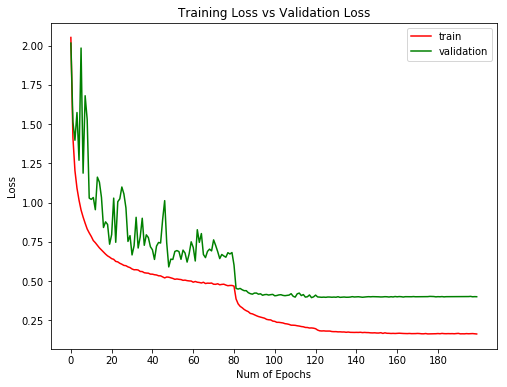

In [21]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 200, 20))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
